# Percolation analysis

* read a network
* drop the links
* add links based on some measure (for example, link weight)

* we measure on scale (0-1) how quickly they make a one complete component
* Percolation = |N_LCC|/|N|


In [1]:
import pandas as pd 
import networkx as nx
import community
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman
import os
from DA import pls_da1
datasets = ["\dolphins\dolphins.gml",
            "\polbooks\out2.txt",
            "\word_adjacencies.gml\word_adjacencies.gml",
            "\\arenas-email\\out2.txt",
            "Karate",
            "Erdos Renyi",
            "\\USAir97\\USAir97.mtx", 
            "\\circuits\s208_st.txt",
            "\\circuits\s420_st.txt",
            "\\circuits\s838_st.txt",
            "\\E. Coli\E. Coli.txt",
            "Barabasi_albert_graph",
            "\\facebook\\0.edges",
            "\\facebook\\107.edges",
            "\\facebook\\348.edges",
            "\\facebook\\414.edges",
            "\\facebook\\686.edges",
            "\\facebook\\1684.edges",
            "\\bio-celegans\\bio-celegans.mtx",
            "\\bn-macaque-rhesus_brain_2\\bn-macaque-rhesus_brain_2.txt",
            '\\soc-tribes\\soc-tribes.txt',
            '\\fb-pages-food\\fb-pages-food.txt',
            '\\bn-cat-mixed-species_brain_1\\bn-cat-mixed-species_brain_1.txt',
            '\\ca-sandi_auths\\ca-sandi_auths.mtx',
            '\\soc-firm-hi-tech\\soc-firm-hi-tech.txt']

def read_graph2(g):
    file_name = 'standard networks dataset' + datasets[int(g)]
    print(file_name)
    G = nx.Graph()
    if g==4:
        G = nx.karate_club_graph()
    elif g==5:
        # nodes = int(input("enter number of nodes?"))
        # edges= int(input("enter number of edges?"))
        G = nx.gnm_random_graph(500, 1500)
    elif g==11:
        # nodes = int(input("enter number of nodes?"))
        # edges= int(input("enter number of edges?"))
        # p = int(input("enter P value?"))
        G = nx.barabasi_albert_graph(500, 3)
    else:
        ext = os.path.splitext(file_name)[1]
        if ext=='.edges':
            G = nx.read_adjlist(file_name, create_using = nx.Graph(), nodetype = int)
        elif ext=='.gml':
            G = nx.read_gml(file_name)
        elif ext=='.mtx':
            G = None
            #matrix = scipy.io.mmread(file_name)
            #G = nx.from_scipy_sparse_matrix(matrix)
        elif ext=='.txt':
            file = open(file_name, 'r')
            lines=  file.readlines()
            G = nx.Graph()
            for line in lines:
                if " " in line:
                    N = line.split(" ")
                else:
                    N = line.split("\t")
                G.add_edge(N[0], N[1])
    return G

# read the networks
networks = {}
for net in range(len(datasets)):
    g = read_graph2(net)
    if g:
        networks[datasets[net]] = g


standard networks dataset\dolphins\dolphins.gml
standard networks dataset\polbooks\out2.txt
standard networks dataset\word_adjacencies.gml\word_adjacencies.gml
standard networks dataset\arenas-email\out2.txt
standard networks datasetKarate
standard networks datasetErdos Renyi
standard networks dataset\USAir97\USAir97.mtx
standard networks dataset\circuits\s208_st.txt
standard networks dataset\circuits\s420_st.txt
standard networks dataset\circuits\s838_st.txt
standard networks dataset\E. Coli\E. Coli.txt
standard networks datasetBarabasi_albert_graph
standard networks dataset\facebook\0.edges
standard networks dataset\facebook\107.edges
standard networks dataset\facebook\348.edges
standard networks dataset\facebook\414.edges
standard networks dataset\facebook\686.edges
standard networks dataset\facebook\1684.edges
standard networks dataset\bio-celegans\bio-celegans.mtx
standard networks dataset\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
standard networks dataset\soc-tribes

In [2]:
name = ['dolphins',
 'polbooks',
 'word_adjacencies',
 'arenas-email',
 'Karate',
 'Erdos Renyi',
 'circuits s208_st',
 'circuits s420_st',
 'circuits s838_st',
 'E. Coli',
 'Barabasi_albert_graph',
 'facebook0',
 'facebook107',
 'facebook348',
 'facebook414',
 'facebook686',
 'facebook1684',
 'bn-macaque-rhesus_brain_2',
 'soc-tribes',
 'fb-pages-food',
 'bn-cat-mixed-species_brain_1',
 'soc-firm-hi-tech']

In [6]:
nodes = [len(networks[n].nodes()) for n in networks]
edges = [len(networks[n].edges()) for n in networks]

pd.DataFrame({'$|N|$': nodes, '$|E|$': edges}).

,$|N|$,$|E|$
0,62,159
1,190,441
2,112,425
3,1893,5451
4,34,78
5,500,1500
6,122,189
7,252,399
8,512,819
9,1699,3758


In [4]:
def weighted_edges(G, C):
    '''return a weighted edges'''
    W = []
    for u,v in G.edges():
        W.append([u, v, C[u]*C[v]])
    return sorted(W, key=lambda x: x[2])

def batch_list(lst):
    """
    Divide a list into batches of an equal number of items (as close to 50 as possible).
    """
    batch_size = (len(lst) + 49) // 50  # Calculate the batch size
    num_batches = (len(lst) + batch_size - 1) // batch_size
    batches = [lst[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    return batches

def simulation(centr):
    results = []
    for network in networks.keys():
        print(network)
        G0 = networks[network]
        bc_G0 = centr(G0)
        W = weighted_edges(G0, bc_G0)
        G = nx.Graph()
        G.add_nodes_from(G0.nodes())
        batches = batch_list(W)

        result = []
        for b in range(len(batches)):
            for u,v,_ in batches[b]:
                G.add_edge(u, v)
            largest_component = G.subgraph(max(nx.connected_components(G), key=len))
            result.append([b, len(largest_component)/len(G)])
        results.append(result)
    return results


In [5]:
def plot(results, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=600)
    fig, ax = plt.subplots()
    markers = ['+', 'x', 'o', 's', 'd', 'D', '*'] # Add your desired markers here
    for d in range(len(results)):
        data = results[d]
        x = [item[0] for item in data]
        y = [item[1] for item in data]
        marker_idx = d % len(markers) # Choose marker based on index of the result
        ax.plot(x, y, marker=markers[marker_idx], linewidth=0.5, markersize=3, label=name[d])

    ax.set_xlabel('edges')
    ax.set_ylabel(r'$|N_{LCC}| / |N| $')
    ax.set_title(f'{title}-based weighted edges')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


\dolphins\dolphins.gml
\polbooks\out2.txt
\word_adjacencies.gml\word_adjacencies.gml
\arenas-email\out2.txt
Karate
Erdos Renyi
\circuits\s208_st.txt
\circuits\s420_st.txt
\circuits\s838_st.txt
\E. Coli\E. Coli.txt
Barabasi_albert_graph
\facebook\0.edges
\facebook\107.edges
\facebook\348.edges
\facebook\414.edges
\facebook\686.edges
\facebook\1684.edges
\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
\soc-tribes\soc-tribes.txt
\fb-pages-food\fb-pages-food.txt
\bn-cat-mixed-species_brain_1\bn-cat-mixed-species_brain_1.txt
\soc-firm-hi-tech\soc-firm-hi-tech.txt


<Figure size 3840x2880 with 0 Axes>

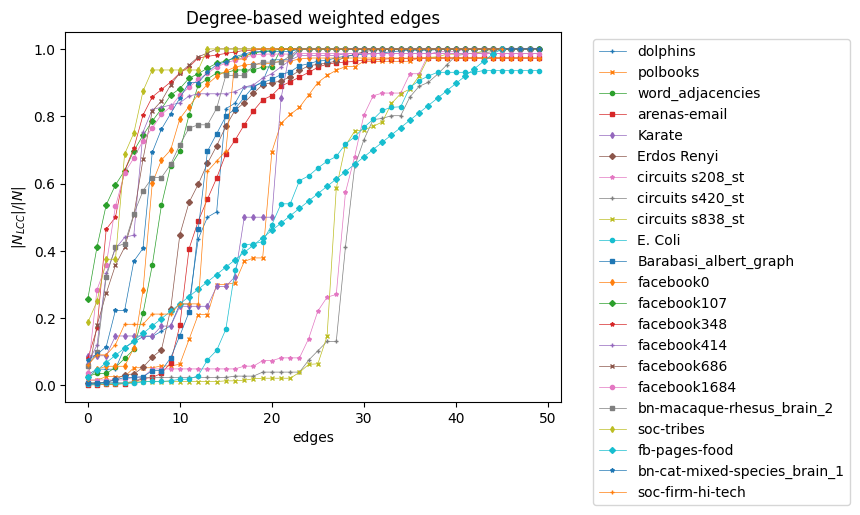

\dolphins\dolphins.gml
\polbooks\out2.txt
\word_adjacencies.gml\word_adjacencies.gml
\arenas-email\out2.txt
Karate
Erdos Renyi
\circuits\s208_st.txt
\circuits\s420_st.txt
\circuits\s838_st.txt
\E. Coli\E. Coli.txt
Barabasi_albert_graph
\facebook\0.edges
\facebook\107.edges
\facebook\348.edges
\facebook\414.edges
\facebook\686.edges
\facebook\1684.edges
\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
\soc-tribes\soc-tribes.txt
\fb-pages-food\fb-pages-food.txt
\bn-cat-mixed-species_brain_1\bn-cat-mixed-species_brain_1.txt
\soc-firm-hi-tech\soc-firm-hi-tech.txt


<Figure size 3840x2880 with 0 Axes>

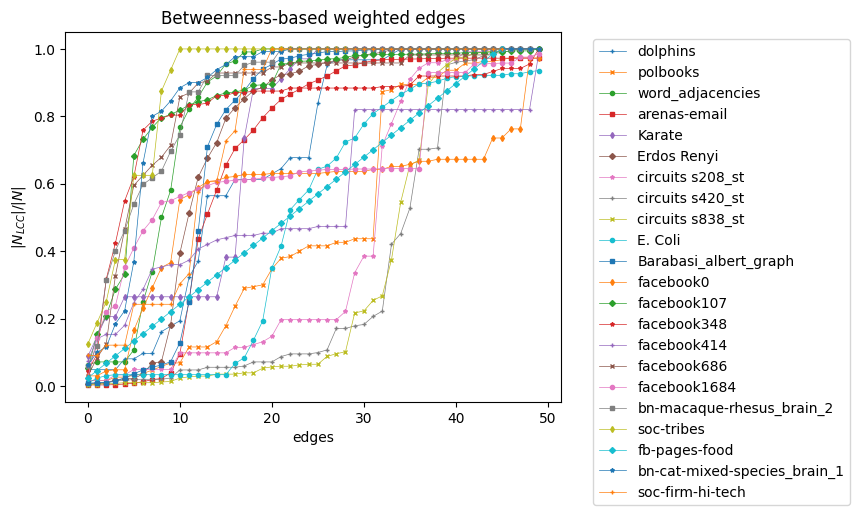

\dolphins\dolphins.gml
\polbooks\out2.txt
\word_adjacencies.gml\word_adjacencies.gml
\arenas-email\out2.txt
Karate
Erdos Renyi
\circuits\s208_st.txt
\circuits\s420_st.txt
\circuits\s838_st.txt
\E. Coli\E. Coli.txt
Barabasi_albert_graph
\facebook\0.edges
\facebook\107.edges
\facebook\348.edges
\facebook\414.edges
\facebook\686.edges
\facebook\1684.edges
\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
\soc-tribes\soc-tribes.txt
\fb-pages-food\fb-pages-food.txt
\bn-cat-mixed-species_brain_1\bn-cat-mixed-species_brain_1.txt
\soc-firm-hi-tech\soc-firm-hi-tech.txt


<Figure size 3840x2880 with 0 Axes>

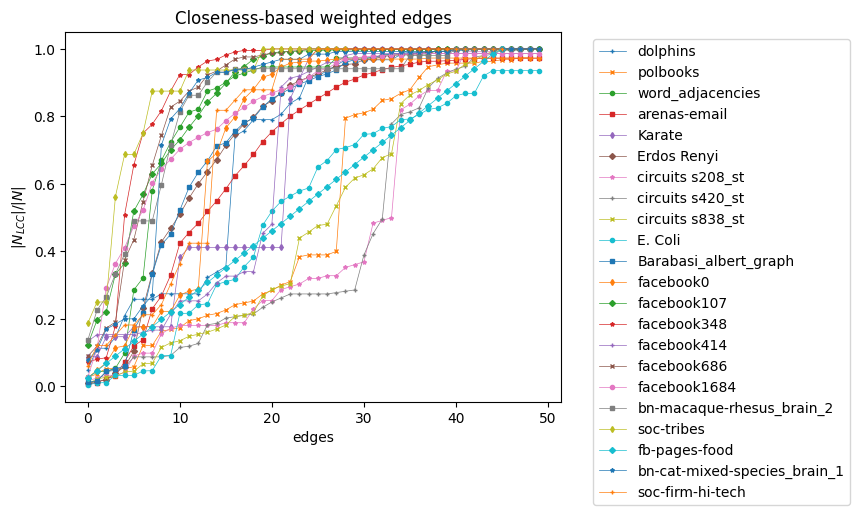

\dolphins\dolphins.gml
\polbooks\out2.txt
\word_adjacencies.gml\word_adjacencies.gml
\arenas-email\out2.txt
Karate
Erdos Renyi
\circuits\s208_st.txt
\circuits\s420_st.txt
\circuits\s838_st.txt
\E. Coli\E. Coli.txt
Barabasi_albert_graph
\facebook\0.edges
\facebook\107.edges
\facebook\348.edges
\facebook\414.edges
\facebook\686.edges
\facebook\1684.edges
\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
\soc-tribes\soc-tribes.txt
\fb-pages-food\fb-pages-food.txt
\bn-cat-mixed-species_brain_1\bn-cat-mixed-species_brain_1.txt
\soc-firm-hi-tech\soc-firm-hi-tech.txt


<Figure size 3840x2880 with 0 Axes>

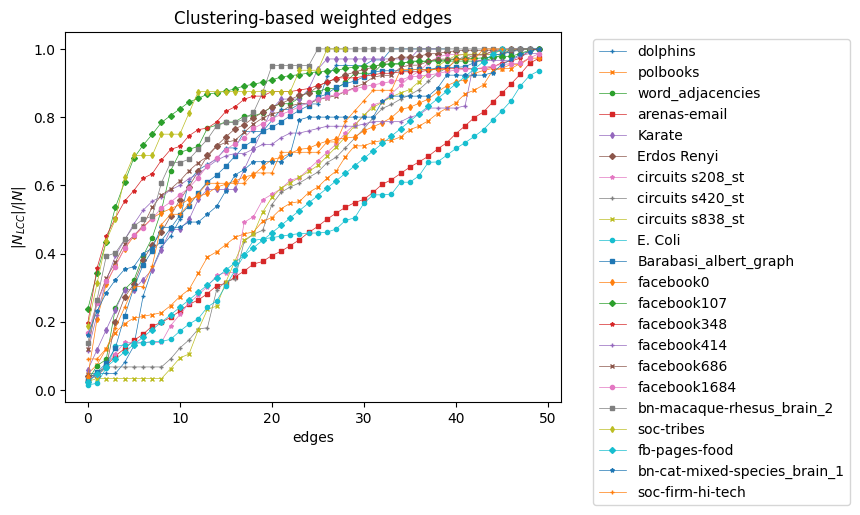

In [6]:
centralities = [nx.degree_centrality, nx.betweenness_centrality, nx.closeness_centrality, nx.clustering]
centr        = ['Degree'            ,   'Betweenness'          ,   'Closeness'          ,   'Clustering']
sims = {}
for i in range(4):
    cent = centr[i]
    sims[cent] = simulation(centralities[i])
    plot(sims[cent], cent)


# Predicting robustness of networks

In [7]:
R = {}
R['Networks'] = name
for c in centr:
    Rs = []
    for i in range(22):
        S = sims[c][i]
        T, V = 0, 0
        for t, v in S:
            if v > V:
                T = t
                V = v
        Rs.append(T)
    R[c] = Rs
pd.DataFrame(R)

,Networks,Degree,Betweenness,Closeness,Clustering
0,dolphins,23,34,35,33
1,polbooks,36,46,47,48
2,word_adjacencies,21,19,38,46
3,arenas-email,37,39,44,49
4,Karate,22,25,25,36
5,Erdos Renyi,36,34,41,46
6,circuits s208_st,41,44,45,45
7,circuits s420_st,46,47,48,48
8,circuits s838_st,46,45,46,47
9,E. Coli,43,49,44,49


<Figure size 3840x2880 with 0 Axes>

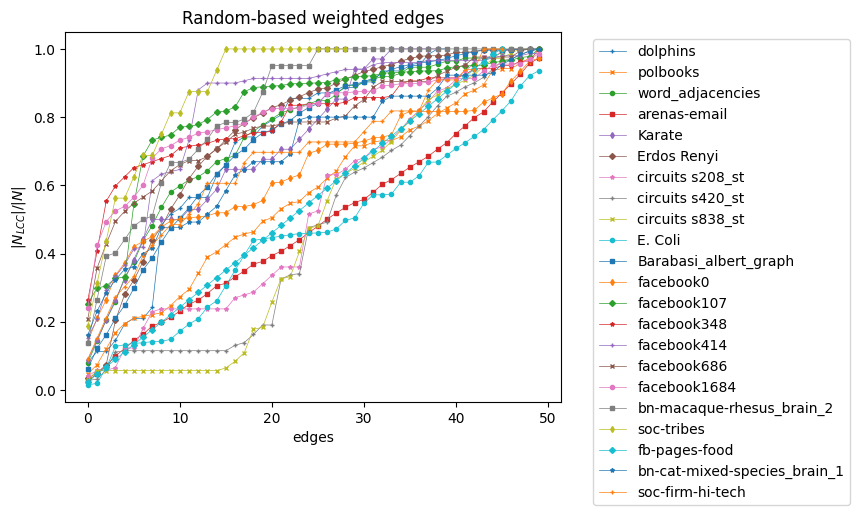

,Networks,Degree,Betweenness,Closeness,Clustering,Random
0,dolphins,23,34,35,33,38
1,polbooks,36,46,47,48,48
2,word_adjacencies,21,19,38,46,46
3,arenas-email,37,39,44,49,49
4,Karate,22,25,25,36,33
5,Erdos Renyi,36,34,41,46,48
6,circuits s208_st,41,44,45,45,46
7,circuits s420_st,46,47,48,48,49
8,circuits s838_st,46,45,46,47,47
9,E. Coli,43,49,44,49,49


In [8]:
def random_sim():
    results = []
    for network in networks.keys():
        G0 = networks[network]
        W = batch_list(list(G0.edges()))
        G = nx.Graph()
        G.add_nodes_from(G0.nodes())
        batches = batch_list(W)

        result = []
        for b in range(len(batches)):
            for (u,v) in batches[b][0]:
                G.add_edge(u, v)
            largest_component = G.subgraph(max(nx.connected_components(G), key=len))
            result.append([b, len(largest_component)/len(G)])
        results.append(result)
    return results

plot(random_sim(), 'Random')
sims_rnd = random_sim()

Rs = []
for i in range(22):
    S = sims_rnd[i]
    T, V = 0, 0
    for t, v in S:
        if v > V:
            T = t
            V = v
    Rs.append(T)
R['Random'] = Rs
pd.DataFrame(R)

In [9]:
def simulation2():
    '''Implementing reverse preferential attachment'''
    results = []
    k = 0.01
    for network in networks.keys():
        print(network)
        G0 = networks[network]
        d = nx.degree_centrality(G0)
        W = [[u, v, (1/((d[u]+k)*(d[v]+k)))] for u,v in G0.edges()]
        W = sorted(W, key=lambda x: x[2])
        G = nx.Graph()
        G.add_nodes_from(G0.nodes())
        batches = batch_list(W)

        result = []
        for b in range(len(batches)):
            for u,v,_ in batches[b]:
                G.add_edge(u, v)
            largest_component = G.subgraph(max(nx.connected_components(G), key=len))
            result.append([b, len(largest_component)/len(G)])
        results.append(result)
    return results


\dolphins\dolphins.gml
\polbooks\out2.txt
\word_adjacencies.gml\word_adjacencies.gml
\arenas-email\out2.txt
Karate
Erdos Renyi
\circuits\s208_st.txt
\circuits\s420_st.txt
\circuits\s838_st.txt
\E. Coli\E. Coli.txt
Barabasi_albert_graph
\facebook\0.edges
\facebook\107.edges
\facebook\348.edges
\facebook\414.edges
\facebook\686.edges
\facebook\1684.edges
\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
\soc-tribes\soc-tribes.txt
\fb-pages-food\fb-pages-food.txt
\bn-cat-mixed-species_brain_1\bn-cat-mixed-species_brain_1.txt
\soc-firm-hi-tech\soc-firm-hi-tech.txt


<Figure size 3840x2880 with 0 Axes>

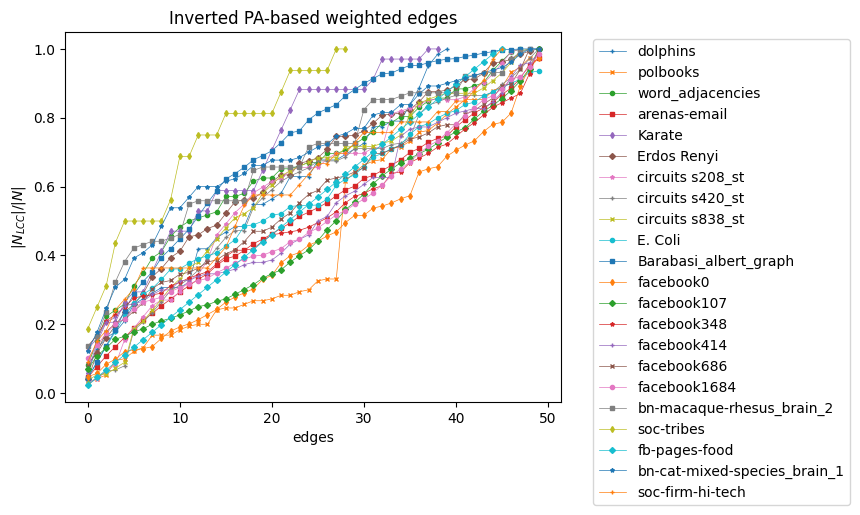

In [10]:
plot(simulation2(), 'Inverted PA')

In [11]:
sims_rnd = simulation2()

Rs = []
for i in range(22):
    S = sims_rnd[i]
    T, V = 0, 0
    for t, v in S:
        if v > V:
            T = t
            V = v
    Rs.append(T)
R['Inverted PA'] = Rs


\dolphins\dolphins.gml
\polbooks\out2.txt
\word_adjacencies.gml\word_adjacencies.gml
\arenas-email\out2.txt
Karate
Erdos Renyi
\circuits\s208_st.txt
\circuits\s420_st.txt
\circuits\s838_st.txt
\E. Coli\E. Coli.txt
Barabasi_albert_graph
\facebook\0.edges
\facebook\107.edges
\facebook\348.edges
\facebook\414.edges
\facebook\686.edges
\facebook\1684.edges
\bn-macaque-rhesus_brain_2\bn-macaque-rhesus_brain_2.txt
\soc-tribes\soc-tribes.txt
\fb-pages-food\fb-pages-food.txt
\bn-cat-mixed-species_brain_1\bn-cat-mixed-species_brain_1.txt
\soc-firm-hi-tech\soc-firm-hi-tech.txt


In [33]:
def properties(G):
    
    GCC = nx.transitivity(G)
    ACC = nx.average_clustering(G)
    d = nx.density(G)
    r = nx.degree_assortativity_coefficient(G)    
    lcg = sorted(nx.connected_components(G), key=len, reverse=True)
    LCG = G.subgraph(lcg[0])    
    ASP = nx.average_shortest_path_length(LCG)
    diam = nx.diameter(LCG)

    communities = greedy_modularity_communities(G)
    mod = nx.community.modularity(G, communities)
    
    return  GCC, ACC, d, r, ASP, diam, mod

In [32]:
network_properties = [properties(networks[g]) for g in networks]

In [38]:
GCCs = [i for i, _,_,_,_,_,_ in network_properties]
ACCs = [i for _, i,_,_,_,_,_ in network_properties]
ds   = [i for _, _,i,_,_,_,_ in network_properties]
rs   = [i for _, _,_,i,_,_,_ in network_properties]
ASPs = [i for _, _,_,_,i,_,_ in network_properties]
diam = [i for _, _,_,_,_,i,_ in network_properties]
comm = [i for _, _,_,_,_,_,i in network_properties]

df2 = pd.DataFrame({'Networks': name, 'GCC': GCCs, 'ACC': ACCs, 'Density': ds, 'r': rs, 'ASP': ASPs, 'Diameter': diam}) 
df2.to_csv('Data/networks properties.csv', index=False)

0     0.495491
1     0.568829
2     0.292878
3     0.581689
4     0.380671
5     0.382149
6     0.678956
7     0.745978
8     0.801635
9     0.583755
10    0.390168
11    0.444891
12    0.458112
13    0.248298
14    0.543767
15    0.289694
16    0.520823
17    0.078871
18    0.168995
19    0.000000
20    0.295192
21    0.313066
Name: mod, dtype: float64

In [58]:
df2 = pd.read_csv('Data/networks properties.csv')
print(df2)

numeric_cols = df2.select_dtypes(include='number').columns
df_quartiles = df2[numeric_cols].apply(lambda x: pd.qcut(x.dropna(), q=[0, 0.25, 0.5, 0.75, 1.0], labels=[0.25,0.5,0.75,1]) if x.dtype != object else x)
df_quartiles['Networks'] = df2['Networks']
df_quartiles['Mod']

                        Networks       GCC       ACC   Density         r  \
0                       dolphins  0.308776  0.258958  0.084082 -0.043594   
1                       polbooks  0.000000  0.000000  0.024561 -0.252596   
2               word_adjacencies  0.156935  0.172840  0.068372 -0.129348   
3                   arenas-email  0.000000  0.000000  0.003044 -0.130757   
4                         Karate  0.255682  0.570638  0.139037 -0.475613   
5                    Erdos Renyi  0.011284  0.011966  0.012024 -0.019343   
6               circuits s208_st  0.057361  0.059094  0.025606 -0.002013   
7               circuits s420_st  0.051680  0.056085  0.012616 -0.005911   
8               circuits s838_st  0.048368  0.054650  0.006261 -0.030017   
9                        E. Coli  0.000000  0.000000  0.002605 -0.338126   
10         Barabasi_albert_graph  0.027735  0.054249  0.011952 -0.106266   
11                     facebook0  0.425869  0.508245  0.045570  0.236039   
12          

D:\Documents\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0     0.75
1     1.00
2     0.25
3     1.00
4     0.50
5     0.50
6     1.00
7     1.00
8     1.00
9     1.00
10    0.50
11    0.75
12    0.75
13    0.25
14    0.75
15    0.25
16    0.75
17    0.25
18    0.25
19    0.25
20    0.50
21    0.50
Name: Mod, dtype: category
Categories (4, float64): [0.25 < 0.50 < 0.75 < 1.00]

In [ ]:
df1 = pd.DataFrame(R)

medians = df1.median()
print(medians)
for column in df1.columns :
    if column!= 'Networks':
        median = medians[column]  # Retrieve the median for the column
        df1[column] = (df1[column] < median).astype(int)


In [50]:
Dataset = pd.merge(df_quartiles, df1, on='Networks')
Dataset = Dataset.reindex(columns = ['Networks', 'GCC', 'Mod', 'Density', 'r', 'ASP', 'Diameter', 'Degree',
       'Betweenness', 'Closeness', 'Clustering', 'Random', 'Inverted PA'])
Dataset.to_csv('Data/vulnerability output.csv', index=False)
Dataset

                        Networks   GCC   ACC  Density     r   ASP  Diameter  \
0                       dolphins  0.75  0.75     0.75  0.50  0.75      0.75   
1                       polbooks  0.25  0.25     0.50  0.25  1.00      0.75   
2               word_adjacencies  0.75  0.75     0.75  0.50  0.50      0.25   
3                   arenas-email  0.25  0.25     0.25  0.25  1.00      1.00   
4                         Karate  0.75  1.00     1.00  0.25  0.25      0.25   
5                    Erdos Renyi  0.50  0.50     0.25  0.75  0.75      0.50   
6               circuits s208_st  0.50  0.50     0.50  0.75  1.00      1.00   
7               circuits s420_st  0.50  0.50     0.50  0.75  1.00      1.00   
8               circuits s838_st  0.50  0.50     0.25  0.75  1.00      1.00   
9                        E. Coli  0.25  0.25     0.25  0.25  1.00      0.75   
10         Barabasi_albert_graph  0.50  0.50     0.25  0.50  0.75      0.50   
11                     facebook0  0.75  0.75     0.5

,Networks,GCC,Mod,Density,r,ASP,Diameter,Degree,Betweenness,Closeness,Clustering,Random,Inverted PA
0,dolphins,NaN,0.75,NaN,NaN,NaN,NaN,1,1,1,1,1,1
1,polbooks,NaN,1.00,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,word_adjacencies,NaN,0.25,NaN,NaN,NaN,NaN,1,1,1,1,1,1
3,arenas-email,NaN,1.00,NaN,NaN,NaN,NaN,0,1,0,0,0,0
4,Karate,NaN,0.50,NaN,NaN,NaN,NaN,1,1,1,1,1,1
5,Erdos Renyi,NaN,0.50,NaN,NaN,NaN,NaN,0,1,0,0,1,0
6,circuits s208_st,NaN,1.00,NaN,NaN,NaN,NaN,0,1,0,1,1,1
7,circuits s420_st,NaN,1.00,NaN,NaN,NaN,NaN,0,0,0,0,0,0
8,circuits s838_st,NaN,1.00,NaN,NaN,NaN,NaN,0,0,0,1,1,0
9,E. Coli,NaN,1.00,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [61]:
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score

data = pd.read_csv('Data/velnerability output.csv')
oldR = {}
X = data.loc[:, ['GCC', 'Mod', 'Density', 'r', 'ASP', 'Diameter']]
for c in [ 'Degree', 'Betweenness', 'Closeness', 'Clustering', 'Random', 'Inverted PA']:
    Y = data[c]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=19)
    oldR[c] = pls_da1(X_train, y_train, X_test).tolist()

oldR


{'Degree': [[0.06696207987369303],
  [-0.13230098077982239],
  [0.1599431132407792],
  [-0.11881401038015739],
  [-0.13425358933267478],
  [-0.011843988108878835]],
 'Betweenness': [[-0.07926044121287615],
  [-0.10305597651805994],
  [-0.01742187896983303],
  [-0.1305827950464431],
  [-0.07798754078515323],
  [-0.10838826864077536]],
 'Closeness': [[0.26241819157052076],
  [-0.023427929209140132],
  [0.12094556794338683],
  [0.09997766831739852],
  [-0.030803781742749163],
  [0.0023727024040473936]],
 'Clustering': [[0.046583881298715754],
  [-0.03366947528118539],
  [0.06137456850485035],
  [-0.1321680039640735],
  [-0.05666003606349563],
  [-0.018226429590813657]],
 'Random': [[0.018545410776077655],
  [-0.08873619352559452],
  [-0.0418723397237486],
  [-0.04955758134183315],
  [-0.04036917132831357],
  [-0.06621901867758771]],
 'Inverted PA': [[0.37142108649575],
  [-0.09172229898758763],
  [-0.05498222747087208],
  [-0.3313532188406827],
  [0.11984416511693528],
  [-0.1333165352859

In [62]:
R = {c: [i[0] for i in oldR[c]] for c in oldR}
R['Measures'] = ['GCC', 'Mod', 'Density', 'r', 'ASP', 'Diameter']
pd.DataFrame(R)

,Degree,Betweenness,Closeness,Clustering,Random,Inverted PA,Measures
0,0.066962,-0.079260,0.262418,0.046584,0.018545,0.371421,GCC
1,-0.132301,-0.103056,-0.023428,-0.033669,-0.088736,-0.091722,Mod
2,0.159943,-0.017422,0.120946,0.061375,-0.041872,-0.054982,Density
3,-0.118814,-0.130583,0.099978,-0.132168,-0.049558,-0.331353,r
4,-0.134254,-0.077988,-0.030804,-0.056660,-0.040369,0.119844,ASP
5,-0.011844,-0.108388,0.002373,-0.018226,-0.066219,-0.133317,Diameter


In [63]:
pd.DataFrame(R).to_csv('Data/final with mod.csv', index=False)